# XGBoost v.3

### Purpose of this notebook
Last XGBoost overfit time series data and thus its accuracy in predicting 2019 data was lower than test and validation data. Try to decrease overfitting by:

- delete day_of_year and other not useful features
- add more features that appear to have good correlation with ESPW
- don't shuffle train/test split so model validates and tests against 'unknown' days of data

In [496]:
# import libraries
import datetime
import boto3
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
import sagemaker
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [497]:
# set up session, region, bucket
sm_boto3 = boto3.client('sagemaker')
# smclient = boto3.Session().client('sagemaker')
sess = sagemaker.Session()

#region = sess.boto_session.region_name

#bucket = sess.default_bucket()  # this could also be a hard-coded bucket name
role = get_execution_role()
#print(role)
####

region = boto3.Session().region_name

In [498]:
bucket = '***'

In [1]:
# load dataframe
path2 = r"***"
xls2 = pd.ExcelFile(path2)
df = pd.read_excel(xls2)
df.dropna(how='all', inplace=True)


NameError: name 'pd' is not defined

***
### Data processing and feature engineering

In [500]:
df['hour'] = df['hour'].astype('int') - 1
df = df[df.hour.astype('int') <= 23]

In [501]:
df['hour'] = ['0'+str(x) if len(str(x)) == 1 else str(x) for x in df['hour']]

In [2]:
df['date_and_time'] = pd.to_datetime(df['Delivery Date'].astype(str) + ' ' + df['hour'].astype('str') )


NameError: name 'pd' is not defined

In [3]:
df.set_index('date_and_time',inplace=True)


NameError: name 'df' is not defined

In [504]:
# some feature engineering

df.drop("Info Available Date", axis = 1, inplace=True)
df.drop("Delivery Date", axis = 1, inplace = True)
df["Day_of_week"] = df.index.weekday

df["day_of_year"] = df.index.dayofyear
df["week_of_year"] = df.index.weekofyear

df['month'] = df.index.month

df['IsAfterApril19'] = [0 if x.year < 2019 and x.month < 4 else 1 for x in df.index]

df['IsWeekend'] = [1 if x==5 or x==6 else 0 for x in df["Day_of_week"]]

df["NetSpain"] = df['ntc FR --> ES'] - df['ntc ES --> FR']

df.columns = df.columns.str.strip().str.replace(' ', '').str.replace('-', '').str.replace('>', '')
df.head()

,hour,demandforecast,windforecast,solarpvforecast,nukeavail,thermalgap,ntcFRES,ntcESFR,Gas,ESPW,Day_of_week,day_of_year,week_of_year,month,IsAfterApril19,IsWeekend,NetSpain
date_and_time,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,00,27003.2,1761,0,7117.2,18125.0,3000,2650,24.675,58.82,6,1,52,1,0,1,350
2017-01-01 01:00:00,01,24283.1,1807,0,7117.2,15358.9,3000,2650,24.675,58.23,6,1,52,1,0,1,350
2017-01-01 02:00:00,02,22369.4,1819,0,7117.2,13433.2,3000,2650,24.675,51.95,6,1,52,1,0,1,350
2017-01-01 03:00:00,03,21220.9,1802,0,7117.2,12301.7,3000,2650,24.675,47.27,6,1,52,1,0,1,350
2017-01-01 04:00:00,04,20351.2,1765,0,7117.2,11469.0,3000,2650,24.675,45.49,6,1,52,1,0,1,350


In [505]:
df['solarwind'] = df["windforecast"] + df["solarpvforecast"]

In [506]:
df["hour"] = df["hour"].astype('int')
df.dtypes

hour                 int64
demandforecast     float64
windforecast         int64
solarpvforecast      int64
nukeavail          float64
thermalgap         float64
ntcFRES              int64
ntcESFR              int64
Gas                float64
ESPW               float64
Day_of_week          int64
day_of_year          int64
week_of_year         int64
month                int64
IsAfterApril19       int64
IsWeekend            int64
NetSpain             int64
solarwind            int64
dtype: object

In [507]:
df["hour4a"] = [1 if x in [0,1,2,3] else 0 for x in df["hour"]]
df["hour4b"] = [1 if x in [4,5,6,7] else 0 for x in df["hour"]]
df["hour4c"] = [1 if x in [8,9,10,11] else 0 for x in df["hour"]]
df["hour4d"] = [1 if x in [12,13,14,15] else 0 for x in df["hour"]]
df["hour4e"] = [1 if x in [16,17,18,19] else 0 for x in df["hour"]]
df["hour4f"] = [1 if x in [20,21,22,23] else 0 for x in df["hour"]]

In [508]:
df["IsNight"] = [1 if x in [23,0,1,2,3,4,5] else 0 for x in df["hour"]]

In [509]:
df.columns = df.columns.str.strip().str.replace(' ', '').str.replace('-', '').str.replace('>', '')
df.dropna(inplace = True)

In [510]:
df.columns

Index(['hour', 'demandforecast', 'windforecast', 'solarpvforecast',
       'nukeavail', 'thermalgap', 'ntcFRES', 'ntcESFR', 'Gas', 'ESPW',
       'Day_of_week', 'day_of_year', 'week_of_year', 'month', 'IsAfterApril19',
       'IsWeekend', 'NetSpain', 'solarwind', 'hour4a', 'hour4b', 'hour4c',
       'hour4d', 'hour4e', 'hour4f', 'IsNight'],
      dtype='object')

In [21]:
df.drop(["day_of_year",'IsAfterApril19','ntcFRES','solarwind'], axis = 1, inplace = True)

In [511]:
df["hour3a"] = [1 if x in [0,1,2] else 0 for x in df["hour"]]
df["hour3b"] = [1 if x in [3,4,5] else 0 for x in df["hour"]]
df["hour3c"] = [1 if x in [6,7,8] else 0 for x in df["hour"]]
df["hour3d"] = [1 if x in [9,10,11] else 0 for x in df["hour"]]
df["hour3e"] = [1 if x in [12,13,14] else 0 for x in df["hour"]]
df["hour3f"] = [1 if x in [15,16,17] else 0 for x in df["hour"]]
df["hour3g"] = [1 if x in [18,19,20] else 0 for x in df["hour"]]
df["hour3h"] = [1 if x in [21,22,23] else 0 for x in df["hour"]]

In [512]:
df["IsNight2"] = [1 if x in [23,0,1,2,3,4,5,6] else 0 for x in df["hour"]]

In [247]:
df.corr()

,hour,demandforecast,windforecast,solarpvforecast,nukeavail,thermalgap,ntcFRES,ntcESFR,Gas,ESPW,...,IsNight,hour3a,hour3b,hour3c,hour3d,hour3e,hour3f,hour3g,hour3h,IsNight2
hour,1.000000,0.537281,0.060680,0.225522,-0.000634,0.403956,0.123027,-0.281621,0.009601,0.245895,...,-0.562714,-0.573191,-0.409625,-0.245800,-0.081974,0.081851,0.245676,0.409502,0.573327,-0.612816
demandforecast,0.537281,1.000000,0.058933,0.423139,0.086576,0.770580,0.163730,-0.393227,0.142739,0.484590,...,-0.602275,-0.329068,-0.479596,-0.149106,0.217126,0.268304,0.145094,0.208423,0.118690,-0.658706
windforecast,0.060680,0.058933,1.000000,-0.168680,0.102512,-0.544513,0.155095,0.063792,0.093754,-0.387728,...,0.031041,0.033185,-0.010871,-0.043438,-0.085290,-0.045653,0.020543,0.064521,0.067017,0.022006
solarpvforecast,0.225522,0.423139,-0.168680,1.000000,-0.026354,0.281526,0.098519,-0.241133,-0.083414,0.064592,...,-0.510837,-0.300809,-0.300972,-0.234529,0.268662,0.598368,0.376243,-0.111234,-0.295852,-0.561972
nukeavail,-0.000634,0.086576,0.102512,-0.026354,1.000000,-0.137448,0.088386,0.061248,0.109672,0.055041,...,0.002376,0.002324,0.000535,-0.001279,-0.001596,-0.000279,-0.000956,0.000276,0.000976,0.002173
thermalgap,0.403956,0.770580,-0.544513,0.281526,-0.137448,1.000000,0.018360,-0.355987,0.072350,0.658267,...,-0.459549,-0.256668,-0.366185,-0.058978,0.193637,0.145612,0.039765,0.173454,0.129259,-0.494467
ntcFRES,0.123027,0.163730,0.155095,0.098519,0.088386,0.018360,1.000000,0.128181,0.039068,0.003699,...,-0.222817,-0.148337,-0.114990,0.045540,0.047958,0.049383,0.097040,0.112925,-0.089579,-0.205563
ntcESFR,-0.281621,-0.393227,0.063792,-0.241133,0.061248,-0.355987,0.128181,1.000000,0.005330,-0.173165,...,0.409365,0.324424,0.182155,-0.083820,-0.092560,-0.088081,-0.116234,-0.123101,-0.002653,0.379528
Gas,0.009601,0.142739,0.093754,-0.083414,0.109672,0.072350,0.039068,0.005330,1.000000,0.606485,...,-0.011516,-0.008246,-0.008514,0.002793,0.002793,0.002793,0.002793,0.002793,0.002793,-0.010451
ESPW,0.245895,0.484590,-0.387728,0.064592,0.055041,0.658267,0.003699,-0.173165,0.606485,1.000000,...,-0.265222,-0.122080,-0.249615,-0.020088,0.107221,0.064387,-0.008646,0.123646,0.105126,-0.285402


In [62]:
df.columns

Index(['hour', 'demandforecast', 'windforecast', 'solarpvforecast',
       'nukeavail', 'thermalgap', 'ntcESFR', 'Gas', 'ESPW', 'Day_of_week',
       'week_of_year', 'month', 'IsWeekend', 'NetSpain', 'hour4a', 'hour4b',
       'hour4c', 'hour4d', 'hour4e', 'hour4f', 'IsNight', 'IsNight2', 'hour3a',
       'hour3b', 'hour3c', 'hour3d', 'hour3e', 'hour3f', 'hour3g', 'hour3h'],
      dtype='object')

In [513]:
df.drop(['hour4a', 'hour3a','day_of_year','NetSpain','hour4d','hour3d','hour4f','hour4b','hour3b','hour4c','hour3c','hour3h','week_of_year','month','IsAfterApril19','solarwind','hour4e','IsNight','hour3g'], axis = 1, inplace = True)

In [514]:
predictors =df.columns.drop(["ESPW"]).tolist()
target = 'ESPW'

In [515]:
df.head()

,hour,demandforecast,windforecast,solarpvforecast,nukeavail,thermalgap,ntcFRES,ntcESFR,Gas,ESPW,Day_of_week,IsWeekend,hour3e,hour3f,IsNight2
date_and_time,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0,27003.2,1761,0,7117.2,18125.0,3000,2650,24.675,58.82,6,1,0,0,1
2017-01-01 01:00:00,1,24283.1,1807,0,7117.2,15358.9,3000,2650,24.675,58.23,6,1,0,0,1
2017-01-01 02:00:00,2,22369.4,1819,0,7117.2,13433.2,3000,2650,24.675,51.95,6,1,0,0,1
2017-01-01 03:00:00,3,21220.9,1802,0,7117.2,12301.7,3000,2650,24.675,47.27,6,1,0,0,1
2017-01-01 04:00:00,4,20351.2,1765,0,7117.2,11469.0,3000,2650,24.675,45.49,6,1,0,0,1


In [516]:
# Splitting into train,test, validation set
X_train, X_validation, y_train, y_validation = train_test_split(df[predictors],df[target],test_size = 0.2, shuffle = True)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.2, shuffle = True)

In [517]:
# must insert target variable as first column so model can read it properly
trainX = pd.DataFrame(X_train, columns=predictors)
trainX.insert(0, 'target', y_train)

#trainX['target'] = y_train

validationX = pd.DataFrame(X_validation, columns=predictors)
validationX.insert(0, 'target', y_validation)
# testX['target'] = y_test

testX = pd.DataFrame(X_test, columns=predictors)
testX.insert(0, 'target', y_test)
# testX['target'] = y_test

In [518]:
# check to see if target variable is first
trainX.head()

,target,hour,demandforecast,windforecast,solarpvforecast,nukeavail,thermalgap,ntcFRES,ntcESFR,Gas,Day_of_week,IsWeekend,hour3e,hour3f,IsNight2
date_and_time,,,,,,,,,,,,,,,
2017-09-26 08:00:00,55.20,8,30754.9,2026,351,6508.5,21869.4,2700,1600,18.376667,1,0,0,0,0
2017-12-21 00:00:00,62.07,0,28146.7,6472,0,7117.2,14557.5,2400,3250,26.996667,3,0,0,0,1
2018-03-08 23:00:00,43.53,23,29829.3,8959,0,6071.9,14798.4,2500,2600,22.793333,3,0,0,0,1
2017-09-21 09:00:00,54.54,9,31482.8,882,1052,7117.2,22431.6,2100,2700,18.063333,3,0,0,0,0
2018-06-26 10:00:00,63.87,10,33890.4,328,2015,6071.9,25475.5,2400,2000,22.930000,1,0,0,0,0


In [519]:
#mask = (trainX['thermalgap']<=0)
#trainX['thermalgap'][mask] = 0

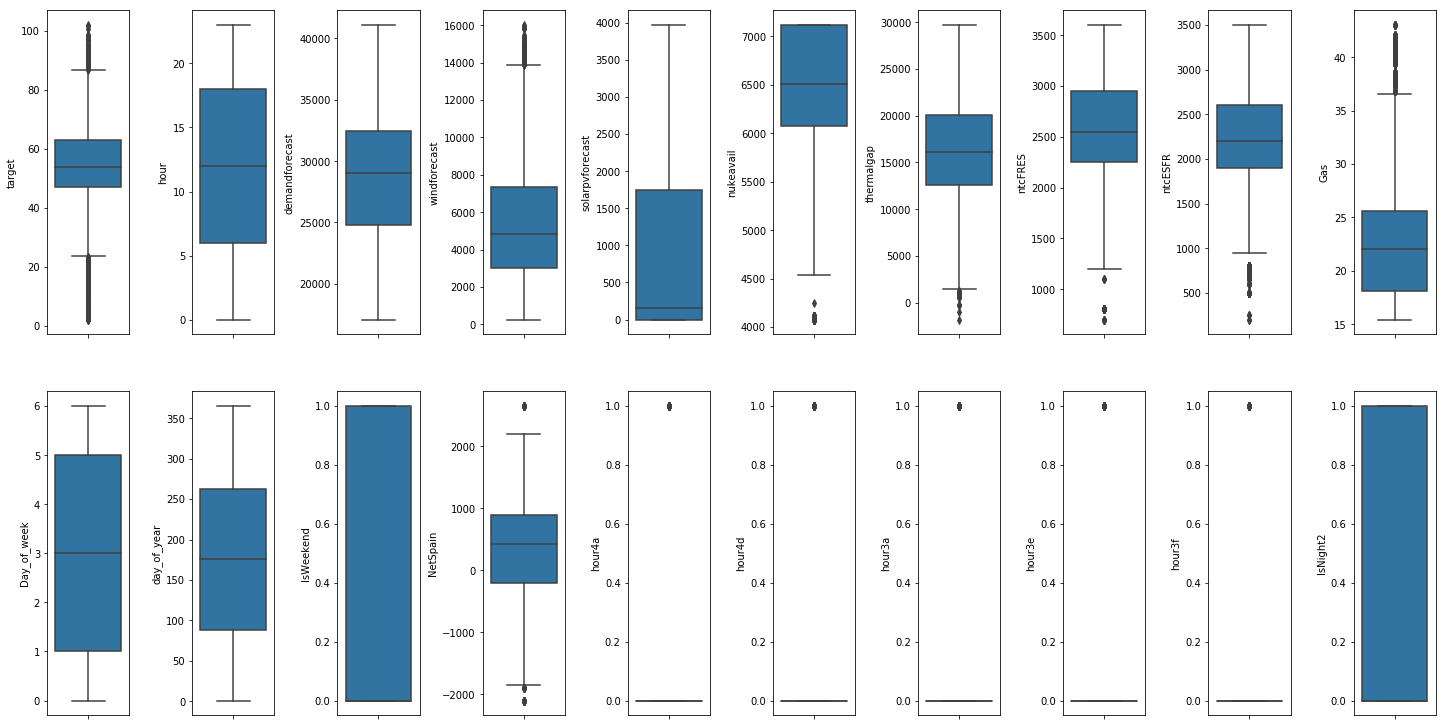

In [421]:
# looking at feature distribution
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=math.ceil(len(trainX.columns)/2), nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in trainX.items():
    sns.boxplot(y=k, data=trainX, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [520]:
# saves to jupyter notebook
# cannot have 'headers' or text in XGBoost
trainX.to_csv('XGBOOST3_train_EV.csv', header=False, index=False)
validationX.to_csv('XGBOOST3_validation_EV.csv', header=False, index=False)
testX.to_csv('XGBOOST3_test_EV.csv', header=False, index=False)


In [521]:
# send data to S3. SageMaker will take training data from s3

trainpath = sess.upload_data(
    path='XGBOOST3_train_EV.csv', bucket=bucket,
    key_prefix='data/Spain_Energy')

validationpath = sess.upload_data(
    path='XGBOOST3_validation_EV.csv', bucket=bucket,
    key_prefix='data/Spain_Energy')

testpath = sess.upload_data(
    path='XGBOOST3_test_EV.csv', bucket=bucket,
    key_prefix='data/Spain_Energy')

In [522]:
# XGBoost
from sagemaker.amazon.amazon_estimator import get_image_uri

#sess = sagemaker.Session()

training_image = get_image_uri(sess.boto_region_name, 'xgboost', repo_version = '0.90-1')

# setting up paths to train, validation, and test sets
s3_input_train = sagemaker.s3_input(s3_data=trainpath, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=validationpath, content_type='csv')
s3_input_test = sagemaker.s3_input(s3_data=testpath, content_type='csv')

In [523]:
xgb = sagemaker.estimator.Estimator(training_image,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, 'XGBOOST3'),
                                    sagemaker_session=sess)

In [524]:
xgb.set_hyperparameters(eval_metric='mae',
                        num_round=100#,
                        #rate_drop=0.3#,
                        #tweedie_variance_power=1.4
                        #alpha = 0.0001
                       )

In [525]:
# tuning
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10),
                        'subsample': ContinuousParameter(0,1),
                         'lambda': ContinuousParameter(0,2),
                        
                         
                        
                            'gamma': ContinuousParameter(0,3),
                           
                        }


In [526]:
objective_metric_name = 'validation:mae'

In [527]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3
                            ,objective_type='Minimize'
                           ,early_stopping_type='Auto')

In [528]:
#s3_input_train 
#s3_input_validation
# start tuning job
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation},include_cls_metadata=False
         )

In [532]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [533]:
# run this cell to check current status of hyperparameter tuning job
sage_client = boto3.Session().client('sagemaker')

tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)

In [534]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2019, 10, 7, 16, 32, 7, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
                                                 'Value': 3.0039000511169434},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2019, 10, 7, 16, 34, 53, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-1:046892354747:training-job/sagemaker-xgboost-191007-1632-001-35d38716',
 'TrainingJobName': 'sagemaker-xgboost-191007-1632-001-35d38716',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2019, 10, 7, 16, 34, 7, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.341922535419589',
                          'eta': '0.7078337863845341',
                          'gamma': '0.2098554301400608',
                          'lambda': '1.1298271945989589',
                          'max_depth': '2',
                          'min_child_weight': '4.

In [ ]:
# shuffle with all parameters (indlucing day_of_year) and shuffle = False
Best model found so far:
{'CreationTime': datetime.datetime(2019, 10, 7, 12, 52, 42, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
                                                 'Value': 5.984179973602295},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2019, 10, 7, 12, 55, 24, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-1:046892354747:training-job/sagemaker-xgboost-191007-1245-008-ad119dd6',
 'TrainingJobName': 'sagemaker-xgboost-191007-1245-008-ad119dd6',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2019, 10, 7, 12, 54, 32, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.45202601969858414',
                          'eta': '0.4749405325015239',
                          'max_depth': '10',
                          'min_child_weight': '9.468171989664125',
                          'subsample': '0.9787131949287708'}}



In [ ]:
## shuggle and less parameters + thermal gap less than 0 set to 0
Best model found so far:
{'CreationTime': datetime.datetime(2019, 10, 7, 10, 58, 23, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
                                                 'Value': 6.6313300132751465},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2019, 10, 7, 11, 1, 19, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-1:046892354747:training-job/sagemaker-xgboost-191007-1052-008-d7b5f509',
 'TrainingJobName': 'sagemaker-xgboost-191007-1052-008-d7b5f509',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2019, 10, 7, 11, 0, 28, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.008233910712685883',
                          'eta': '0.3115997136421953',
                          'max_depth': '3',
                          'min_child_weight': '2.3330061967168456',
                          'subsample': '0.9221741686216813'}}


## non shuffle and less parameters
Best model found so far:
{'CreationTime': datetime.datetime(2019, 10, 7, 9, 36, 36, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
                                                 'Value': 6.226550102233887},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2019, 10, 7, 9, 39, 17, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-1:046892354747:training-job/sagemaker-xgboost-191007-0932-005-7f1b334f',
 'TrainingJobName': 'sagemaker-xgboost-191007-0932-005-7f1b334f',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2019, 10, 7, 9, 38, 27, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.233365800766002',
                          'eta': '0.30668593967184066',
                          'max_depth': '4',
                          'min_child_weight': '8.028340548156056',
                          'subsample': '0.4870305806444375'}}

## non shuffle and more parameters

Best model found so far:
{'CreationTime': datetime.datetime(2019, 10, 7, 8, 53, 30, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
                                                 'Value': 6.371399879455566},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2019, 10, 7, 8, 56, 36, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-1:046892354747:training-job/sagemaker-xgboost-191007-0853-001-54c83351',
 'TrainingJobName': 'sagemaker-xgboost-191007-0853-001-54c83351',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2019, 10, 7, 8, 55, 45, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.5070673514139874',
                          'eta': '0.4012839396410879',
                          'max_depth': '9',
                          'min_child_weight': '9.817460746760016',
                          'subsample': '0.5145457465505991'}}
                          

In [ ]:
# shuffle, less parameters from feature_importance gain
Best model found so far:
{'CreationTime': datetime.datetime(2019, 10, 7, 14, 42, 14, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
                                                 'Value': 1.7040599584579468},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2019, 10, 7, 14, 44, 55, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-1:046892354747:training-job/sagemaker-xgboost-191007-1423-019-a497cb55',
 'TrainingJobName': 'sagemaker-xgboost-191007-1423-019-a497cb55',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2019, 10, 7, 14, 44, 4, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.46987848608019034',
                          'eta': '0.22018665608020793',
                          'gamma': '1.8352526749809115',
                          'lambda': '2.0',
                          'max_depth': '10',
                          'min_child_weight': '1.7012544476167863',
                          'subsample': '0.8012568697556464'}}

In [193]:
results = tuner.analytics().dataframe()
results

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,eta,max_depth,min_child_weight,subsample
0,7.135960,55.0,2019-10-07 11:13:53+00:00,sagemaker-xgboost-191007-1052-020-415676e4,Completed,2019-10-07 11:12:58+00:00,1.840348,0.371841,1.0,1.807486,0.851942
1,7.876410,49.0,2019-10-07 11:13:40+00:00,sagemaker-xgboost-191007-1052-019-a1054177,Completed,2019-10-07 11:12:51+00:00,0.518174,0.852660,6.0,5.973776,0.989649
2,64.434097,52.0,2019-10-07 11:12:51+00:00,sagemaker-xgboost-191007-1052-018-3a56e5df,Completed,2019-10-07 11:11:59+00:00,1.814469,0.000000,3.0,5.391226,0.621718
3,64.434097,46.0,2019-10-07 11:11:09+00:00,sagemaker-xgboost-191007-1052-017-b2c3719a,Stopped,2019-10-07 11:10:23+00:00,0.951044,0.000000,9.0,7.884123,0.891138
4,64.434097,52.0,2019-10-07 11:10:20+00:00,sagemaker-xgboost-191007-1052-016-dc8784de,Completed,2019-10-07 11:09:28+00:00,0.299372,0.000000,3.0,7.757506,0.949579
5,8.226960,52.0,2019-10-07 11:09:52+00:00,sagemaker-xgboost-191007-1052-015-358baabc,Completed,2019-10-07 11:09:00+00:00,1.719132,0.857479,8.0,8.015135,0.878717
6,6.863010,52.0,2019-10-07 11:07:52+00:00,sagemaker-xgboost-191007-1052-014-80dcddc1,Completed,2019-10-07 11:07:00+00:00,0.162958,0.314723,3.0,9.602385,0.976587
7,8.223430,61.0,2019-10-07 11:07:24+00:00,sagemaker-xgboost-191007-1052-013-35a00756,Completed,2019-10-07 11:06:23+00:00,1.786454,0.989772,9.0,6.910734,0.953394
8,6.992060,51.0,2019-10-07 11:06:47+00:00,sagemaker-xgboost-191007-1052-012-9558334c,Completed,2019-10-07 11:05:56+00:00,0.111689,0.207077,7.0,1.255149,0.960230
9,7.642750,55.0,2019-10-07 11:04:35+00:00,sagemaker-xgboost-191007-1052-011-f0484f8a,Completed,2019-10-07 11:03:40+00:00,0.086076,0.969173,1.0,9.358763,0.846388


Best model found so far:
{'CreationTime': datetime.datetime(2019, 10, 1, 15, 37, 54, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
                                                 'Value': 1.7122600078582764},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2019, 10, 1, 15, 40, 37, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-1:046892354747:training-job/sagemaker-xgboost-191001-1526-012-b8a2027d',
 'TrainingJobName': 'sagemaker-xgboost-191001-1526-012-b8a2027d',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2019, 10, 1, 15, 39, 36, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.12865960226560244',
                          'eta': '0.23594604412163345',
                          'max_depth': '10',
                          'min_child_weight': '8.849915751206105',
                          'subsample': '0.9897238455522395'}}

In [460]:
# deploy tuner and predict

# for loading when tuning was just run

endpoint_name = 'team-bob-xgboost-shuffle-off-BEST-of-BEST-endpoint'

xgb_predictor = tuner.deploy(initial_instance_count = 1,instance_type = 'ml.t2.large'
                            , endpoint_name = endpoint_name
                            )

2019-10-07 14:44:55 Starting - Preparing the instances for training
2019-10-07 14:44:55 Downloading - Downloading input data
2019-10-07 14:44:55 Training - Training image download completed. Training in progress.
2019-10-07 14:44:55 Uploading - Uploading generated training model
2019-10-07 14:44:55 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:mae to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value mae to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[14:44:44] 10780x1

In [461]:
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer 

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

In [462]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')






In [463]:
testX = pd.read_csv("XGBOOST3_test_EV.csv", header = None)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,46.10,23,27143.2,8285,0,7117.2,11741.0,2800,1800,17.400000,0,65,0,1000,0,0,0,0,0,1
1,76.24,9,31423.5,9103,1001,7117.2,14202.3,3300,2200,29.256667,0,274,0,1100,0,0,0,0,0,0
2,65.04,21,31723.0,5354,0,6121.4,20247.6,2500,1600,26.026667,2,339,0,900,0,0,0,0,0,0
3,51.01,15,30168.2,1982,3414,7117.2,17655.0,1700,700,18.110000,0,93,0,1000,0,1,0,0,1,0
4,49.97,7,28651.5,4258,335,6121.4,17937.1,2200,1250,17.333333,1,164,0,950,0,0,0,0,0,0
5,73.69,18,36610.6,4104,31,7117.2,25358.4,2600,2200,28.500000,1,3,0,400,0,0,0,0,0,0
6,36.61,0,25685.8,10586,0,5066.1,10033.7,2750,3000,21.226667,4,124,0,-250,1,0,1,0,0,1
7,56.89,9,32161.8,1319,1079,4112.2,25651.6,2150,750,17.903333,4,153,0,1400,0,0,0,0,0,0
8,64.69,16,25293.4,1923,2810,7117.2,13443.2,3000,1900,27.216667,6,238,1,1100,0,0,0,0,1,0
9,63.81,11,30823.5,740,2715,6071.9,21296.6,2800,1650,24.736667,5,195,1,1150,0,0,0,0,0,0


In [464]:
y_true = testX.iloc[:,0]


In [465]:
predictions = predict(testX.drop(0, axis=1).as_matrix())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [466]:
print('MAE: ', mean_absolute_error(y_true, predictions))
print('Median AE: ', median_absolute_error(y_true, predictions))

MAE:  1.659933747490011
Median AE:  1.1061283874511716


#### Compare performance metrics from different models

In [ ]:
# original
MAE:  1.737527948053725
Median AE:  1.234809417724609

In [ ]:
# for non-shuffle, less parameters
MAE:  5.133020827494318
Median AE:  4.385112266540528

In [ ]:
# shuffle, less parameters
MAE:  5.527412595515435
Median AE:  4.978884201049805

In [ ]:
# all, non-shuffle
MAE:  7.394949577555105
Median AE:  6.9599258422851555

In [ ]:
# feature_importance, gain/loss 
MAE:  1.659933747490011
Median AE:  1.1061283874511716

#### Create report output

In [68]:
test_df = pd.DataFrame(testX, columns = testX.columns.tolist())

,target,hour,demandforecast,windforecast,solarpvforecast,nukeavail,thermalgap,ntcFRES,ntcESFR,Gas,...,IsWeekend,NetSpain,solarwind,hour4a,hour4b,hour4c,hour4d,hour4e,hour4f,IsNight
date_and_time,,,,,,,,,,,,,,,,,,,,,
2018-05-25 02:00:00,63.49,2,23164.7,5271,0,5068.5,12825.2,1850,3000,24.160000,...,0,-1150,5271,1,0,0,0,0,0,1
2017-11-05 11:00:00,38.90,11,25038.5,7855,2313,5061.6,9808.9,3000,3100,21.480000,...,1,-100,10168,0,0,1,0,0,0,0
2018-04-18 08:00:00,55.43,8,31698.9,3614,665,5066.1,22353.8,2400,1400,20.950000,...,0,1000,4279,0,0,1,0,0,0,0
2018-05-05 17:00:00,46.54,17,25085.4,4922,2001,5066.1,13096.3,3350,2500,20.460000,...,1,850,6923,0,0,0,0,1,0,0
2017-09-11 17:00:00,44.27,17,32475.3,7725,2253,7117.2,15380.1,2250,2200,17.300000,...,0,50,9978,0,0,0,0,1,0,0
2017-07-22 11:00:00,50.19,11,31445.9,1001,2546,6105.9,21793.0,2650,2150,16.636667,...,1,500,3547,0,0,1,0,0,0,0
2017-02-13 12:00:00,54.69,12,34916.0,9812,1780,7117.2,16206.8,3500,2550,22.550000,...,0,950,11592,0,0,0,1,0,0,0
2017-04-18 16:00:00,40.49,16,32352.5,7002,2784,7117.2,15449.3,2700,2700,18.140000,...,0,0,9786,0,0,0,0,1,0,0
2018-04-02 01:00:00,25.31,1,21423.6,9759,0,6071.9,5592.7,1600,1800,20.663333,...,0,-200,9759,1,0,0,0,0,0,1


In [69]:
test_df['target_pred'] = predictions
test_df

,target,hour,demandforecast,windforecast,solarpvforecast,nukeavail,thermalgap,ntcFRES,ntcESFR,Gas,...,NetSpain,solarwind,hour4a,hour4b,hour4c,hour4d,hour4e,hour4f,IsNight,target_pred
date_and_time,,,,,,,,,,,,,,,,,,,,,
2018-05-25 02:00:00,63.49,2,23164.7,5271,0,5068.5,12825.2,1850,3000,24.160000,...,-1150,5271,1,0,0,0,0,0,1,60.135151
2017-11-05 11:00:00,38.90,11,25038.5,7855,2313,5061.6,9808.9,3000,3100,21.480000,...,-100,10168,0,0,1,0,0,0,0,43.714542
2018-04-18 08:00:00,55.43,8,31698.9,3614,665,5066.1,22353.8,2400,1400,20.950000,...,1000,4279,0,0,1,0,0,0,0,57.759266
2018-05-05 17:00:00,46.54,17,25085.4,4922,2001,5066.1,13096.3,3350,2500,20.460000,...,850,6923,0,0,0,0,1,0,0,43.421558
2017-09-11 17:00:00,44.27,17,32475.3,7725,2253,7117.2,15380.1,2250,2200,17.300000,...,50,9978,0,0,0,0,1,0,0,45.330559
2017-07-22 11:00:00,50.19,11,31445.9,1001,2546,6105.9,21793.0,2650,2150,16.636667,...,500,3547,0,0,1,0,0,0,0,51.295574
2017-02-13 12:00:00,54.69,12,34916.0,9812,1780,7117.2,16206.8,3500,2550,22.550000,...,950,11592,0,0,0,1,0,0,0,53.302933
2017-04-18 16:00:00,40.49,16,32352.5,7002,2784,7117.2,15449.3,2700,2700,18.140000,...,0,9786,0,0,0,0,1,0,0,46.556393
2018-04-02 01:00:00,25.31,1,21423.6,9759,0,6071.9,5592.7,1600,1800,20.663333,...,-200,9759,1,0,0,0,0,0,1,19.371977


In [71]:
test_df.to_csv('***')

sess.upload_data(
    path='***', bucket=bucket,
    key_prefix='***')

's3://team-bob-sagemaker-bucket-1309219/predictions/XGBoost2/XGBoost2_test_predictions.csv'

#### Extracting feature importance from model artifact

In [72]:
testX.columns.tolist()

['target',
 'hour',
 'demandforecast',
 'windforecast',
 'solarpvforecast',
 'nukeavail',
 'thermalgap',
 'ntcFRES',
 'ntcESFR',
 'Gas',
 'Day_of_week',
 'day_of_year',
 'week_of_year',
 'month',
 'IsAfterApril19',
 'IsWeekend',
 'NetSpain',
 'solarwind',
 'hour4a',
 'hour4b',
 'hour4c',
 'hour4d',
 'hour4e',
 'hour4f',
 'IsNight']

In [97]:
!conda install -y -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    xgboost-0.90               |   py36he1b5a44_2          11 KB  conda-forge
    py-xgboost-0.90            |   py36he1b5a44_2          73 KB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    libxgboost-0.90            |       he1b5a44_2         2.4 MB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.7 MB



In [617]:
import s3fs
import pickle
import tarfile
import xgboost

model_path = 's3://team-bob-sagemaker-bucket-1309219/XGBOOST3/output/sagemaker-xgboost-191007-1423-019-a497cb55/output/model.tar.gz'
fs = s3fs.S3FileSystem()

f = fs.open(model_path, 'rb') 

tar_f = tarfile.open(fileobj=f, mode='r')



extracted_f = tar_f.extractfile('xgboost-model')
xgbooster = pickle.load(extracted_f)

feature_importance = xgbooster.get_score(importance_type='total_gain')
feature_importance

{'f8': 1221023.0,
 'f5': 1388865.0,
 'f7': 313296.0,
 'f4': 177256.0,
 'f9': 222801.0,
 'f10': 1108297.0,
 'f1': 1055043.0,
 'f17': 27184.0,
 'f14': 9207.0,
 'f2': 976543.0,
 'f3': 377887.0,
 'f6': 286469.0,
 'f12': 254763.0,
 'f0': 529720.0,
 'f18': 10625.0,
 'f16': 4514.0}

In [618]:
set(feature_importance.values())

{4514.0,
 9207.0,
 10625.0,
 27184.0,
 177256.0,
 222801.0,
 254763.0,
 286469.0,
 313296.0,
 377887.0,
 529720.0,
 976543.0,
 1055043.0,
 1108297.0,
 1221023.0,
 1388865.0}

In [619]:
df.columns[2]

'windforecast'

In [486]:
set1 = set(feature_importance.keys())
set2 = set(xgbooster.feature_names)
set2-set1

{'f11', 'f13', 'f15'}

In [ ]:
{'f5': 1150715.2285398226,
 'f8': 694695.9515453969,
 'f6': 19839.970186887334,
 'f9': 10963.912756675112,
 'f15': 11223.753563972386,
 'f10': 122426.66213102968,
 'f1': 15019.669624227157,
 'f3': 9329.631696976325,
 'f0': 9938.802729212466,
 'f7': 38013.99734444407,
 'f2': 20110.537364318203,
 'f4': 20653.611800149094,
 'f16': 13528.386829632584,
 'f11': 5295.858922395003,
 'f26': 398.1382850020001,
 'f29': 1830.714155165,
 'f20': 452.18073924370003,
 'f32': 1140.0807704230003,
 'f25': 1286.872898991,
 'f18': 777.5486666854998,
 'f21': 642.1960052440003,
 'f27': 498.742490444,
 'f30': 2157.8073632829996,
 'f28': 109.76268827700001,
 'f19': 391.40167599100005,
 'f23': 165.25475508899999}

In [361]:
xgbooster.feature_names

['f0',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'f9',
 'f10',
 'f11',
 'f12',
 'f13',
 'f14',
 'f15',
 'f16',
 'f17',
 'f18',
 'f19',
 'f20',
 'f21',
 'f22',
 'f23',
 'f24',
 'f25',
 'f26',
 'f27',
 'f28',
 'f29',
 'f30',
 'f31',
 'f32']

In [495]:
df.columns[15]

'hour4d'

In [ ]:
'hour4a', 'hour3a','day_of_year','NetSpain','hour4d'


In [ ]:
{109.76268827700001,
 165.25475508899999,
 391.40167599100005,
 398.1382850020001,
 452.18073924370003,
 498.742490444,

In [387]:
'hour4a', 'hour3a','day_of_year','NetSpain','hour4d','hour3d','hour4f','hour4b','hour3b','hour4c','hour3c','hour3h','week_of_year','month','IsAfterApril19','solarwind','hour4e','IsNight','hour3g'

('hour3d', 'hour4f', 'hour4b', 'hour3b', 'hour4c', 'hour3c', 'hour3h')

In [382]:
set(feature_importance.values())

{4661.0,
 8162.0,
 12049.0,
 17508.0,
 17662.0,
 17936.0,
 18616.0,
 23666.0,
 23674.0,
 25810.0,
 31639.0,
 33297.0,
 58145.0,
 161711.0,
 182975.0,
 260737.0,
 286916.0,
 331753.0,
 350279.0,
 583493.0,
 865756.0,
 1040163.0,
 1066717.0,
 1131317.0,
 1751376.0,
 1907728.0}

#### Clean up

In [ ]:
sm_boto3.delete_endpoint(EndpointName=endpoint_name)

#### Creating visualisations

In [310]:
len(X_train.columns)

33

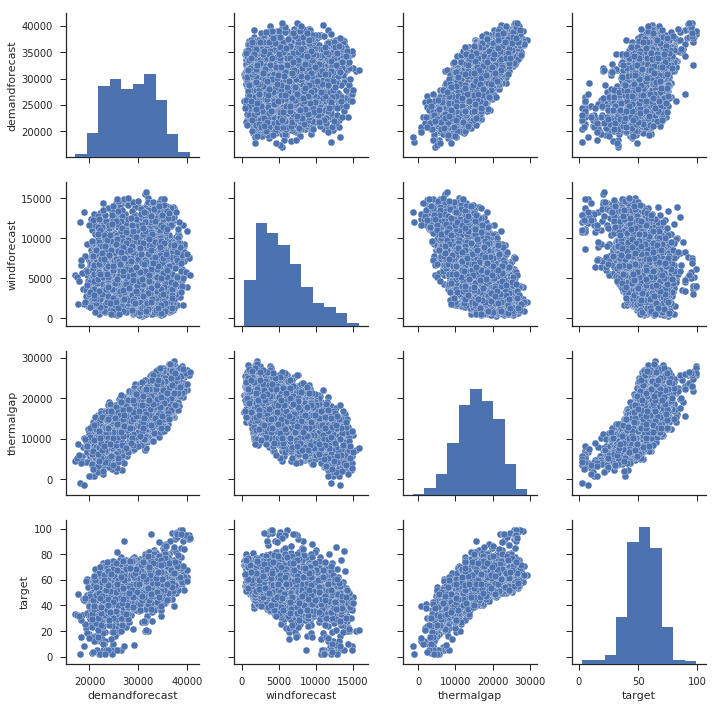

In [126]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(validationX,
             vars=['demandforecast','windforecast', 'thermalgap','target']
            )

In [154]:
validationX

,target,hour,demandforecast,windforecast,solarpvforecast,thermalgap,ntcESFR,Gas,Day_of_week,month,IsWeekend,NetSpain
date_and_time,,,,,,,,,,,,
2018-10-30 01:00:00,53.13,1,23571.4,10657,0,6808.5,2200,27.446667,1,10,0,-250
2017-07-19 15:00:00,50.33,15,36225.6,5738,2861,21520.7,1950,16.586667,2,7,0,-450
2018-09-03 16:00:00,71.68,16,34637.3,4970,2149,20401.1,1100,29.586667,0,9,0,1150
2018-05-19 19:00:00,59.56,19,24747.4,4588,860,14230.9,2150,22.620000,5,5,1,900
2017-12-14 16:00:00,67.14,16,34723.9,10796,386,16424.7,2300,27.560000,3,12,0,700
2017-07-22 14:00:00,49.49,14,32390.8,2928,2971,20385.9,2150,16.636667,5,7,1,500
2017-07-19 16:00:00,50.50,16,36223.8,5891,2611,21615.9,1950,16.586667,2,7,0,-450
2018-04-05 18:00:00,44.49,18,30766.3,6906,1453,16335.4,1200,20.906667,3,4,0,1200
2017-12-24 18:00:00,67.00,18,28220.3,2384,53,18666.1,2600,23.416667,6,12,1,400


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6140013630>,
      dtype=object)

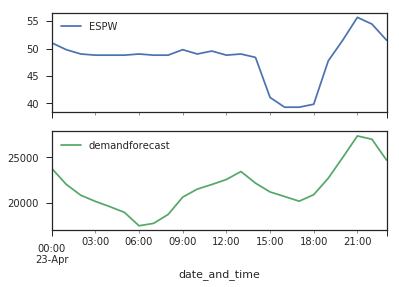

In [152]:
fig, axes = plt.subplots(2,1, sharex=True)
df.loc['2017-04-23', ['ESPW','demandforecast']].plot(subplots=True, ax=axes)

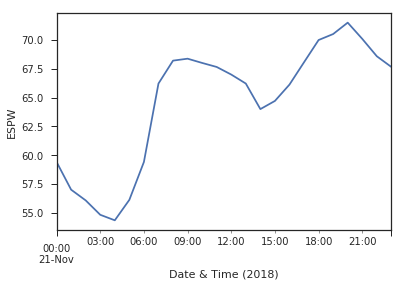

In [142]:
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook

import seaborn as sns
# Use seaborn style defaults and set the default figure size
# sns.set(rc={'figure.figsize':(11, 4)})

ax = df.loc['2018-11-21', 'ESPW'].plot(
    #marker='o', 
    linestyle = '-')
ax.set_ylabel('ESPW')
ax.set_xlabel('Date & Time (2018)');

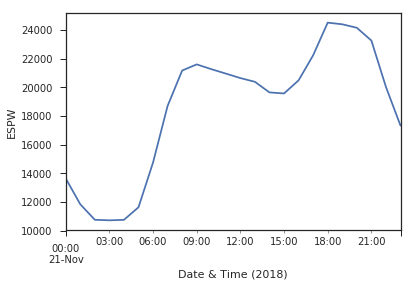

In [141]:
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook

import seaborn as sns
# Use seaborn style defaults and set the default figure size
# sns.set(rc={'figure.figsize':(11, 4)})

ax = df.loc['2018-11-21', 'thermalgap'].plot(
    #marker='o', 
    linestyle = '-')
ax.set_ylabel('ESPW')
ax.set_xlabel('Date & Time (2018)');

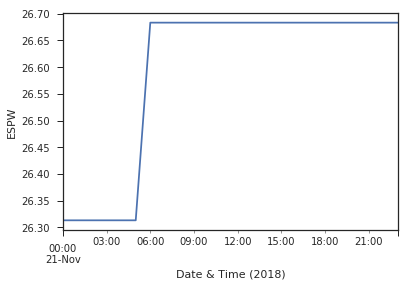

In [144]:
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook

import seaborn as sns
# Use seaborn style defaults and set the default figure size
# sns.set(rc={'figure.figsize':(11, 4)})

ax = df.loc['2018-11-21', 'Gas'].plot(
    #marker='o', 
    linestyle = '-')
ax.set_ylabel('ESPW')
ax.set_xlabel('Date & Time (2018)');

In [157]:
rando_test = df.loc['2017-04-23'].drop('ESPW',axis = 1)

In [156]:
yy_true = df.loc['2017-04-23','ESPW']

In [159]:
ppredictions = predict(rando_test.as_matrix())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [161]:
mean_absolute_error(yy_true,ppredictions)

0.7339830652872722

In [162]:
rando_test['y_pred'] = ppredictions

In [163]:
rando_test['y_true'] = yy_true

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f613fd87dd8>,
      dtype=object)

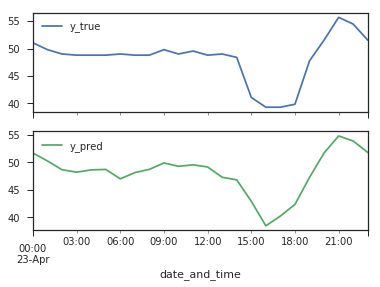

In [166]:
fig, axes = plt.subplots(2,1, sharex=True)
rando_test[['y_true','y_pred']].plot(subplots=True, ax=axes)

***

#### Preparing dataframe for technical hackathon presentation

In [628]:
path2 = r"***"
xls2 = pd.ExcelFile(path2)
df2 = pd.read_excel(xls2)
df2.dropna(how='all', inplace=True)


In [629]:
df2['Hour'] = df2['Hour'].astype('int') - 1

In [630]:
df2 = df2[df2.Hour.astype('int') <= 23]

df2['Hour'] = ['0'+str(x) if len(str(x)) == 1 else str(x) for x in df2['Hour']]

df2['date_and_time'] = pd.to_datetime(df2['Date'].astype(str) + ' ' + df2['Hour'].astype('str') )


In [631]:
df2.rename(columns={"solar pv": "solarpv"},inplace = True)

In [632]:
df2.set_index('date_and_time',inplace=True)
df2.head()

#df2.drop("Date", axis = 1, inplace = True)
df2["Day_of_week"] = df2.index.weekday



df2["day_of_year"] = df2.index.dayofyear
df2["week_of_year"] = df2.index.weekofyear


df2['month'] = df2.index.month


df2['IsAfterApril19'] = [0 if x.year < 2019 and x.month < 4 else 1 for x in df2.index]

df2['IsWeekend'] = [1 if x==5 or x==6 else 0 for x in df2["Day_of_week"]]

df2["NetSpain"] = df2['ntc (Fr --> Es)'] - df2['ntc (Es --> Fr)']

df2.columns = df2.columns.str.strip().str.replace(' ', '').str.replace('-', '').str.replace('>', '')






In [633]:
df2.head()

,Date,Hour,demand,wind,solarpv,nukeavail,ntc(FrEs),thermalgap,ntc(EsFr),gasprice,esda,Day_of_week,day_of_year,week_of_year,month,IsAfterApril19,IsWeekend,NetSpain
date_and_time,,,,,,,,,,,,,,,,,,
2019-10-04 00:00:00,2019-10-04,00,24977,3906,0.0,7117,1800,12154.0,3000,12.31,50.80,4,277,40,10,1,0,-1200
2019-10-04 01:00:00,2019-10-04,01,23793,3660,0.0,7117,1800,11216.0,3000,12.31,50.00,4,277,40,10,1,0,-1200
2019-10-04 02:00:00,2019-10-04,02,23023,3314,0.0,7117,1800,10792.0,3000,12.31,50.15,4,277,40,10,1,0,-1200
2019-10-04 03:00:00,2019-10-04,03,22655,2962,0.0,7117,1600,10976.0,2800,12.31,50.89,4,277,40,10,1,0,-1200
2019-10-04 04:00:00,2019-10-04,04,22512,2792,0.0,7117,1600,11003.0,2800,12.31,51.36,4,277,40,10,1,0,-1200


In [634]:
df2['solarwind'] = df2["wind"] + df2["solarpv"]

In [635]:
df2["Hour4a"] = [1 if x in [0,1,2,3] else 0 for x in df2["Hour"]]
df2["Hour4b"] = [1 if x in [4,5,6,7] else 0 for x in df2["Hour"]]
df2["Hour4c"] = [1 if x in [8,9,10,11] else 0 for x in df2["Hour"]]
df2["Hour4d"] = [1 if x in [12,13,14,15] else 0 for x in df2["Hour"]]
df2["Hour4e"] = [1 if x in [16,17,18,19] else 0 for x in df2["Hour"]]
df2["Hour4f"] = [1 if x in [20,21,22,23] else 0 for x in df2["Hour"]]

In [636]:
df2["hour3a"] = [1 if x in [0,1,2] else 0 for x in df2["Hour"]]
df2["hour3b"] = [1 if x in [3,4,5] else 0 for x in df2["Hour"]]
df2["hour3c"] = [1 if x in [6,7,8] else 0 for x in df2["Hour"]]
df2["hour3d"] = [1 if x in [9,10,11] else 0 for x in df2["Hour"]]
df2["hour3e"] = [1 if x in [12,13,14] else 0 for x in df2["Hour"]]
df2["hour3f"] = [1 if x in [15,16,17] else 0 for x in df2["Hour"]]
df2["hour3g"] = [1 if x in [18,19,20] else 0 for x in df2["Hour"]]
df2["hour3h"] = [1 if x in [21,22,23] else 0 for x in df2["Hour"]]

In [637]:


df2["Hour"] = df2["Hour"].astype('int')
#df2.dtypes

#df2["Hour3b"] = [1 if x in [3,4,5] else 0 for x in df2["Hour"]]
df2["IsNight"] = [1 if x in [23,0,1,2,3,4,5] else 0 for x in df2["Hour"]]
df2["IsNight2"] = [1 if x in [23,0,1,2,3,4,5,6] else 0 for x in df2["Hour"]]

df2.columns = df2.columns.str.strip().str.replace(' ', '').str.replace('-', '').str.replace('>', '')
df2.dropna(inplace = True)

In [638]:
df2

,Date,Hour,demand,wind,solarpv,nukeavail,ntc(FrEs),thermalgap,ntc(EsFr),gasprice,...,hour3a,hour3b,hour3c,hour3d,hour3e,hour3f,hour3g,hour3h,IsNight,IsNight2
date_and_time,,,,,,,,,,,,,,,,,,,,,
2019-10-04 00:00:00,2019-10-04,0,24977,3906,0.0,7117,1800,12154.0,3000,12.31,...,0,0,0,0,0,0,0,0,1,1
2019-10-04 01:00:00,2019-10-04,1,23793,3660,0.0,7117,1800,11216.0,3000,12.31,...,0,0,0,0,0,0,0,0,1,1
2019-10-04 02:00:00,2019-10-04,2,23023,3314,0.0,7117,1800,10792.0,3000,12.31,...,0,0,0,0,0,0,0,0,1,1
2019-10-04 03:00:00,2019-10-04,3,22655,2962,0.0,7117,1600,10976.0,2800,12.31,...,0,0,0,0,0,0,0,0,1,1
2019-10-04 04:00:00,2019-10-04,4,22512,2792,0.0,7117,1600,11003.0,2800,12.31,...,0,0,0,0,0,0,0,0,1,1
2019-10-04 05:00:00,2019-10-04,5,22896,2551,0.0,7117,1600,11628.0,2800,12.31,...,0,0,0,0,0,0,0,0,1,1
2019-10-04 06:00:00,2019-10-04,6,25004,2232,0.0,7117,1800,13855.0,2800,13.39,...,0,0,0,0,0,0,0,0,0,1
2019-10-04 07:00:00,2019-10-04,7,27908,1918,0.0,7117,2100,16773.0,2800,13.39,...,0,0,0,0,0,0,0,0,0,0
2019-10-04 08:00:00,2019-10-04,8,29609,1537,248.5,7117,2100,18606.5,2800,13.39,...,0,0,0,0,0,0,0,0,0,0


In [573]:
df2["predictions"]=ppredictions

In [627]:
df2['target'] = df2["esda"]


KeyError: 'esda'

In [645]:
target = df2['esda']

In [674]:
df2.drop(['predictions','target'], axis = 1,inplace = True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Index(['Hour', 'demand', 'wind', 'solarpv', 'nukeavail', 'thermalgap',
       'ntc(FrEs)', 'ntc(EsFr)', 'gasprice', 'Day_of_week', 'day_of_year',
       'IsWeekend', 'NetSpain', 'Hour4a', 'Hour4d', 'hour3a', 'hour3e',
       'hour3f', 'IsNight2'],
      dtype='object')

***
# Presentation Example: Using XGBoost in a Sagemaker notebook instance

- upload data (df2)
- use predict function to send it to the model endpoint
- print the model evaluation metrics
- plot the results

In [681]:
# upload the new data to make a prediction on (our dataframe is named 'df2')
df2.head()

,Hour,demand,wind,solarpv,nukeavail,thermalgap,ntc(FrEs),ntc(EsFr),gasprice,Day_of_week,day_of_year,IsWeekend,NetSpain,Hour4a,Hour4d,hour3a,hour3e,hour3f,IsNight2
date_and_time,,,,,,,,,,,,,,,,,,,
2019-10-04 00:00:00,0,24977,3906,0.0,7117,12154.0,1800,3000,12.31,4,277,0,-1200,0,0,0,0,0,1
2019-10-04 01:00:00,1,23793,3660,0.0,7117,11216.0,1800,3000,12.31,4,277,0,-1200,0,0,0,0,0,1
2019-10-04 02:00:00,2,23023,3314,0.0,7117,10792.0,1800,3000,12.31,4,277,0,-1200,0,0,0,0,0,1
2019-10-04 03:00:00,3,22655,2962,0.0,7117,10976.0,1600,2800,12.31,4,277,0,-1200,0,0,0,0,0,1
2019-10-04 04:00:00,4,22512,2792,0.0,7117,11003.0,1600,2800,12.31,4,277,0,-1200,0,0,0,0,0,1


In [682]:
# send data to the model using the function: predict()
ppredictions = predict(df2.as_matrix())
ppredictions

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


array([49.41094971, 49.97026443, 48.47492981, 46.32140732, 45.94093323,
       47.94794846, 49.78516769, 53.55761719, 55.66374969, 55.66663361,
       54.30528259, 54.21794128, 54.57984924, 54.39526367, 50.33375549,
       48.88811493, 49.35098267, 50.17127609, 51.25048828, 56.18445969,
       57.49028015, 57.04053879, 53.50669861, 51.01852798])

In [683]:
# evaluate model output against actual data 
print('Median Absolute Error: ',median_absolute_error(target,ppredictions))
print('Mean Absolute Error: ',mean_absolute_error(target,ppredictions3))

Median Absolute Error:  1.2362368011474594
Mean Absolute Error:  1.5598079172770174


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


[None, None]

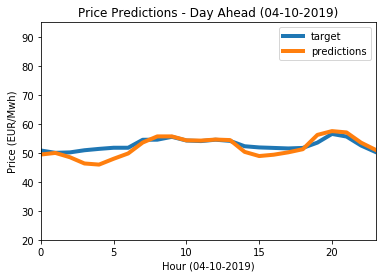

In [684]:
# plot predicted vs. actual values
df2["target"] = target
df2['predictions'] = ppredictions
df2.plot('Hour',['target','predictions'], title = 'Price Predictions - Day Ahead (04-10-2019)',linewidth=4)
axes = plt.gca()
fig= plt.gcf()
axes.set_ylim([20,95])
axes.set_ylabel('Price (EUR/Mwh)')
axes.set_xlabel('Hour (04-10-2019)')

leg = plt.legend()
# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=4)

[None, None]

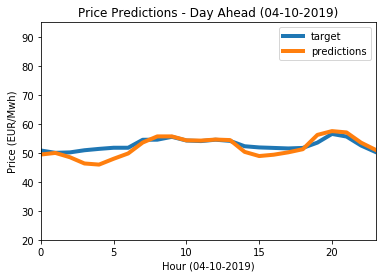

In [608]:
df2.plot('Hour',['target','predictions'], title = 'Price Predictions - Day Ahead (04-10-2019)',linewidth=4)
axes = plt.gca()
fig= plt.gcf()
axes.set_ylim([20,95])
axes.set_ylabel('Price (EUR/Mwh)')
axes.set_xlabel('Hour (04-10-2019)')

leg = plt.legend()
# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=4)


In [639]:
df2 = df2[['Hour', 'demand', 'wind', 'solarpv','nukeavail','thermalgap','ntc(FrEs)',
        'ntc(EsFr)', 'gasprice', 'Day_of_week','day_of_year', 'IsWeekend',
       'NetSpain', 'Hour4a', 'Hour4d','hour3a', 'hour3e', 'hour3f', 'IsNight2']]

In [482]:
ppredictions = predict(df2.as_matrix())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [483]:
median_absolute_error(target,ppredictions)

1.2362368011474594

In [484]:
mean_absolute_error(target,ppredictions)

1.5598079172770174

In [553]:
df2['prediction'] = ppredictions

In [555]:
df2.plot(['esda','prediction'])

ValueError: x must be a label or position

In [ ]:
# write results to csv
ppredictions.to_csv('predictions_XGBOOST3_test_EV.csv')